In [144]:
import pandas as pd
import numpy as np
import prophet
from make_series import *
import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings("ignore")

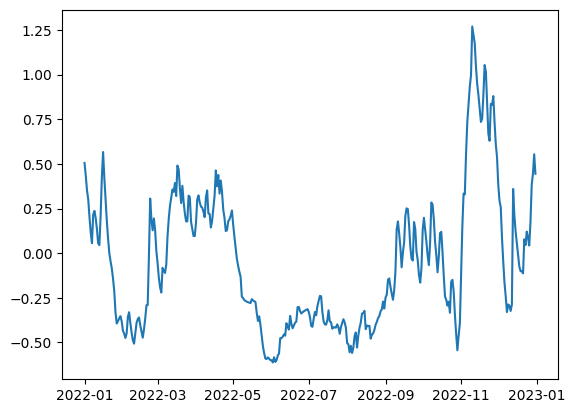

In [145]:
# Соберем нужные данные
df = pd.read_excel('data/normalized_data.xlsx')
series = make_series(df, 'Фастфуд', True)
dates = get_all_dates()

# Сделаем график series
plt.plot(dates, series)
plt.show()

# Сделаем из 2 столбцов датафрейм
df = pd.DataFrame({'ds': dates, 'y': series})

In [146]:
model = prophet.Prophet()
model.fit(df)

01:01:30 - cmdstanpy - INFO - Chain [1] start processing
01:01:30 - cmdstanpy - INFO - Chain [1] done processing


In [147]:
future = model.make_future_dataframe(periods=predictions)
forecast = model.predict(future)

In [148]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2022-01-01,0.050686,-0.357680,0.510977,0.050686,0.050686,0.033873,0.033873,0.033873,0.033873,0.033873,0.033873,0.0,0.0,0.0,0.084559
1,2022-01-02,0.049034,-0.343241,0.488713,0.049034,0.049034,0.037854,0.037854,0.037854,0.037854,0.037854,0.037854,0.0,0.0,0.0,0.086888
2,2022-01-03,0.047383,-0.373300,0.480292,0.047383,0.047383,0.005466,0.005466,0.005466,0.005466,0.005466,0.005466,0.0,0.0,0.0,0.052849
3,2022-01-04,0.045732,-0.365336,0.480012,0.045732,0.045732,-0.004571,-0.004571,-0.004571,-0.004571,-0.004571,-0.004571,0.0,0.0,0.0,0.041161
4,2022-01-05,0.044081,-0.404361,0.423259,0.044081,0.044081,-0.026371,-0.026371,-0.026371,-0.026371,-0.026371,-0.026371,0.0,0.0,0.0,0.017710
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410,2023-02-15,0.504572,0.067017,0.941164,0.490069,0.522268,-0.026371,-0.026371,-0.026371,-0.026371,-0.026371,-0.026371,0.0,0.0,0.0,0.478201
411,2023-02-16,0.508349,0.080421,0.876760,0.493333,0.526596,-0.028202,-0.028202,-0.028202,-0.028202,-0.028202,-0.028202,0.0,0.0,0.0,0.480147
412,2023-02-17,0.512127,0.064117,0.876506,0.496597,0.530852,-0.018049,-0.018049,-0.018049,-0.018049,-0.018049,-0.018049,0.0,0.0,0.0,0.494078
413,2023-02-18,0.515904,0.134580,0.975868,0.499739,0.535349,0.033873,0.033873,0.033873,0.033873,0.033873,0.033873,0.0,0.0,0.0,0.549777


In [149]:
df

,ds,y
0,2022-01-01,0.505544
1,2022-01-02,0.436093
2,2022-01-03,0.351385
3,2022-01-04,0.301530
4,2022-01-05,0.202427
...,...,...
360,2022-12-27,0.173765
361,2022-12-28,0.383523
362,2022-12-29,0.445849
363,2022-12-30,0.553782


In [150]:
cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df.set_index('ds'))
cmp_df

,yhat,yhat_lower,yhat_upper,y
ds,,,,
2022-01-01,0.084559,-0.357680,0.510977,0.505544
2022-01-02,0.086888,-0.343241,0.488713,0.436093
2022-01-03,0.052849,-0.373300,0.480292,0.351385
2022-01-04,0.041161,-0.365336,0.480012,0.301530
2022-01-05,0.017710,-0.404361,0.423259,0.202427
...,...,...,...,...
2023-02-15,0.478201,0.067017,0.941164,NaN
2023-02-16,0.480147,0.080421,0.876760,NaN
2023-02-17,0.494078,0.064117,0.876506,NaN


In [151]:
cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['p'] = 100*cmp_df['e']/cmp_df['y']

cmp_df

,yhat,yhat_lower,yhat_upper,y,e,p
ds,,,,,,
2022-01-01,0.084559,-0.357680,0.510977,0.505544,0.420986,83.273749
2022-01-02,0.086888,-0.343241,0.488713,0.436093,0.349205,80.075781
2022-01-03,0.052849,-0.373300,0.480292,0.351385,0.298536,84.959856
2022-01-04,0.041161,-0.365336,0.480012,0.301530,0.260369,86.349264
2022-01-05,0.017710,-0.404361,0.423259,0.202427,0.184717,91.251202
...,...,...,...,...,...,...
2023-02-15,0.478201,0.067017,0.941164,NaN,NaN,NaN
2023-02-16,0.480147,0.080421,0.876760,NaN,NaN,NaN
2023-02-17,0.494078,0.064117,0.876506,NaN,NaN,NaN


In [152]:
print('MAPE', np.mean(abs(cmp_df['p'])))
print('MAE', np.mean(abs(cmp_df['e'])))

MAPE 125.779287972556
MAE 0.2711042204673863


In [153]:
# Попробуем сделать прогноз на определленую дату
future = model.make_future_dataframe(periods=1)
forecast = model.predict(future)
forecast


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2022-01-01,0.050686,-0.360880,0.528760,0.050686,0.050686,0.033873,0.033873,0.033873,0.033873,0.033873,0.033873,0.0,0.0,0.0,0.084559
1,2022-01-02,0.049034,-0.323425,0.531601,0.049034,0.049034,0.037854,0.037854,0.037854,0.037854,0.037854,0.037854,0.0,0.0,0.0,0.086888
2,2022-01-03,0.047383,-0.349034,0.494618,0.047383,0.047383,0.005466,0.005466,0.005466,0.005466,0.005466,0.005466,0.0,0.0,0.0,0.052849
3,2022-01-04,0.045732,-0.379382,0.469903,0.045732,0.045732,-0.004571,-0.004571,-0.004571,-0.004571,-0.004571,-0.004571,0.0,0.0,0.0,0.041161
4,2022-01-05,0.044081,-0.357977,0.468868,0.044081,0.044081,-0.026371,-0.026371,-0.026371,-0.026371,-0.026371,-0.026371,0.0,0.0,0.0,0.017710
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,2022-12-28,0.319488,-0.148180,0.705474,0.319488,0.319488,-0.026371,-0.026371,-0.026371,-0.026371,-0.026371,-0.026371,0.0,0.0,0.0,0.293117
362,2022-12-29,0.323265,-0.145072,0.698080,0.323265,0.323265,-0.028202,-0.028202,-0.028202,-0.028202,-0.028202,-0.028202,0.0,0.0,0.0,0.295063
363,2022-12-30,0.327042,-0.106297,0.720342,0.327042,0.327042,-0.018049,-0.018049,-0.018049,-0.018049,-0.018049,-0.018049,0.0,0.0,0.0,0.308993
364,2022-12-31,0.330819,-0.056383,0.815873,0.330819,0.330819,0.033873,0.033873,0.033873,0.033873,0.033873,0.033873,0.0,0.0,0.0,0.364692
